In [1]:
import collections
from csv import DictReader
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [2]:
season16_17 = DictReader(open('podatki/season-1617_csv.csv', 'rt', encoding='utf-8'))
season17_18 = DictReader(open('podatki/season-1718_csv.csv', 'rt', encoding='utf-8'))
season18_19 = DictReader(open('podatki/season-1819_csv.csv', 'rt', encoding='utf-8'))
fpl_players18_19  = DictReader(open('podatki/fpl_data_2018_2019.csv', 'rt', encoding='utf-8'))

In [3]:
class Player:
    def __init__(self, apps, goals, wins, losses, header_goals, right_foot_goals,
                 left_foot_goals, pen_score, goals_from_fk, shots, shots_on_targ, shoot_acc_perc, hit_wood,
                 big_chanc_miss, team_play, assist, tckl, tckl_succes_perc, l_m_tackles, blck_shots, interc, clear, h_clear):
        self.apps = apps

        self.goals = goals
        self.wins = wins
        self.losses = losses

        self.header_goals = header_goals
        self.right_foot_goals = right_foot_goals
        self.left_foot_goals = left_foot_goals
        self.pen_score = pen_score
        self.goals_from_fk = goals_from_fk
        self.shots = shots
        self.shot_on_targ = shots_on_targ
        self.shoot_acc_perc = shoot_acc_perc
        self.hit_wood = hit_wood
        self.big_chanc_miss = big_chanc_miss
        self.team_play = team_play
        self.assist = assist
        self.tckl = tckl
        self.tckl_succes_perc = tckl_succes_perc
        self.l_m_tackles = l_m_tackles
        self.blck_shots = blck_shots
        self.interc = interc
        self.clear = clear
        self.h_clear = h_clear
        
    
    def get_all(self):
        return [self.goals, self.header_goals, self.pen_score, self.goals_from_fk, self.shots, self.shot_on_targ, 
               self.shoot_acc_perc, self.hit_wood, self.big_chanc_miss, self.team_play, self.assist, self.tckl,
               self.tckl_succes_perc, self.l_m_tackles, self.blck_shots, self.interc, self.clear, self.h_clear]






class Referee:
    '''
    Podatki na voljo v zvezi s sodnikom:
        Referee = Match Referee
        HF = Home Team Fouls Committed
        AF = Away Team Fouls Committed
        HO = Home Team Offsides
        AO = Away Team Offsides
        HY = Home Team Yellow Cards
        AY = Away Team Yellow Cards
        HR = Home Team Red Cards
        AR = Away Team Red Cards
        HBP = Home Team Bookings Points (10 = yellow, 25 = red)
        ABP = Away Team Bookings Points (10 = yellow, 25 = red)
    '''

    # dict  {ime priimek: objekt}
    # dict[imepriimek].refereed_games

    def __init__(self, name):
        # Ime sodnika v formatu "'Prva črka imena' Priimek"

        self.name = name

        # Sojene tekme: tekme v katerih je bil glaven sodnik
        # Dodajajo se objekti "Match"
        self.refereed_games = []

        # Rumeni kartoni (razdeljeni na domače/goste):
        self.yellow_cards_home = 0
        self.yellow_cards_away = 0

        # Rdeči kartoni:
        self.red_cards_home = 0
        self.red_cards_away = 0

        # Skupno število točk od kartonov (10 = rumen, 25 = rdeč)
        self.booking_points = 0

        # Sojeni prekrški
        self.home_team_fouls = 0
        self.away_team_fouls = 0

    def add_all(self, cards, match):
        self.add_cards(cards)
        self.add_match(match)

    def add_cards(self, cards):
        # cards seznam kartonov v formatu [hy, ay, hr, ar]
        hy = int(cards[0])
        ay = int(cards[1])
        hr = int(cards[2])
        ar = int(cards[3])
        self.yellow_cards_home += hy
        self.yellow_cards_away += ay
        self.red_cards_home += hr
        self.red_cards_away += ar

        self.booking_points += (hy + ay) * 10 + (hr + ar) * 25

    def add_match(self, match):
        self.refereed_games.append(match)

    def to_string(self):
        return (self.name)

    def get_cards(self):
        return ([self.yellow_cards_home + self.yellow_cards_away, self.red_cards_home + self.red_cards_away])


class Match:
    '''
     Podatki na voljo:
        Div = League Division
        Date = Match Date (dd/mm/yy)
        HomeTeam = Home Team
        AwayTeam = Away Team
        FTHG = Full Time Home Team Goals
        FTAG = Full Time Away Team Goals
        FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
        HTHG = Half Time Home Team Goals
        HTAG = Half Time Away Team Goals
        HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)

        Match Statistics (where available)
        Attendance = Crowd Attendance
        Referee = Match Referee
        HTS = Home Team Shots
        ATS = Away Team Shots
        HST = Home Team Shots on Target
        AST = Away Team Shots on Target
        HHW = Home Team Hit Woodwork
        AHW = Away Team Hit Woodwork
        HC = Home Team Corners
        AC = Away Team Corners
        HF = Home Team Fouls Committed
        AF = Away Team Fouls Committed
        HO = Home Team Offsides
        AO = Away Team Offsides
        HY = Home Team Yellow Cards
        AY = Away Team Yellow Cards
        HR = Home Team Red Cards
        AR = Away Team Red Cards
    '''

    def __init__(self, date, home_team, away_team, fthg, ftag, ftr, hthg,
                 htr, hts, ats, hst, ast, hc, ac, hf, af, hy, ay, hr, ar):
        self.date = date
        self.home_team = home_team
        self.away_team = away_team
        self.fthg = fthg
        self.ftag = ftag
        self.ftr = ftr
        self.hthg = hthg
        self.htr = htr
        self.hts = hts
        self.ats = ats
        self.hst = hst
        self.ast = ast
        self.hc = hc
        self.ac = ac
        self.hf = hf
        self.af = af
        self.hy = hy
        self.ay = ay
        self.hr = hr
        self.ar = ar
        self.winner = None
        self.loser = None

        if ftr == "H":
            self.winner = home_team
            self.loser= away_team

        if ftr == "A":
            self.winner = away_team
            self.loser = home_team
        if ftr == "D":
            self.winner = "draw"
            self.loser = "draw"

    def to_string(self):
        out = "{} {}{} - {}{}".format(self.date, self.home_team, self.fthg, self.ftag, self.away_team)
        return out


class Team:
    '''
        Div = League Division
        Date = Match Date (dd/mm/yy)
        FTHG = Full Time Home Team Goals
        FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
        HTHG = Half Time Home Team Goals
        HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)

        Match Statistics (where available)
        Attendance = Crowd Attendance
        Referee = Match Referee
        HS = Home Team Shots
        HST = Home Team Shots on Target
        HHW = Home Team Hit Woodwork
        HC = Home Team Corners
        HF = Home Team Fouls Committed
        HO = Home Team Offsides
        HY = Home Team Yellow Cards
        HR = Home Team Red Cards
        HBP = Home Team Bookings Points (10 = yellow, 25 = red)


    '''

    def __init__(self, name, division, ):
        self.played_games = []
        self.name = name
        self.division = division
        self.goals_scored = 0
        self.goals_conceded = 0
        self.yellow_cards = 0
        self.red_cards = 0
        self.points = 0

        self.win = 0
        self.loss = 0
        self.draw = 0

        self.home_goals = 0
        self.away_goals = 0

        self.home_shots = 0
        self.away_shots = 0

        self.home_shots_on_target = 0
        self.away_shots_on_target = 0

        self.home_points = 0
        self.away_points = 0

        self.half_time_points = 0
        self.half_time_wins = 0
        self.half_time_loss = 0
        self.half_time_draws = 0


    def add_all(self, gs, gc, yc, rc):
        self.goals_scored += int(gs)
        self.goals_conceded += int(gc)
        self.yellow_cards += int(yc)
        self.red_cards += int(rc)

        if gs > gc:
            # self.win += 1
            self.points += 3
        if gs == gc:
            # self.draw += 1
            self.points += 1
        else:
            pass
            # self.loss += 1

    def to_string(self):
        return "{} {}".format(self.name, self.division)




In [4]:
sezone_referees = []
sezone_teams = []


# referee_dict = {}
# {"Ime ekipe": objekt}
# teams_dict = defaultdict(Team)
# teams_dict = {}


def read_data(data):
    referee_dict = {}
    teams_dict = {}
    betting_sites = {"365": 0, "IW": 0, "BW": 0}
    htrs = []
    i_bet = {"365": 0, "IW": 0, "BW": 0}
    for row in data:
        div = row["Div"]
        date = row["Date"]
        home_team = row["HomeTeam"]
        away_team = row["AwayTeam"]
        # home_hit_woodwork = row["HHW"]
        # away_hit_woodwork = row["AHW"]

        full_time_away_goals = row["FTAG"]
        full_time_home_goals = row["FTHG"]
        full_time_result = row["FTR"]
        half_time_home_goals = row["HTHG"]

        htag = row["HTAG"]
        half_time_result = row["HTR"]
        referee = row["Referee"]
        hts = row["HS"]
        ats = row["AS"]
        hst = row["HST"]
        ast = row["AST"]
        home_fouls = row["HF"]
        af = row["AF"]
        # home_team_offsides = row["HO"]
        # away_team_offsides = row["AO"]
        hc = row["HC"]
        ac = row["AC"]
        home_yellow = row["HY"]
        away_yellow = row["AY"]
        home_red = row["HR"]
        away_red = row["AR"]
        '''
        B365H = Bet365 home win odds
        B365D = Bet365 draw odds
        B365A = Bet365 away win odds
        IWH = Interwetten home win odds
        IWD = Interwetten draw odds
        IWA = Interwetten away win odds
        BWH = Bet&Win home win odds
        BWD = Bet&Win draw odds
        BWA = Bet&Win away win odds
        '''

        home_365 = float(row["B365H"])
        draw_365 = float(row["B365D"])
        away_365 = float(row["B365A"])

        home_IW = float(row["IWH"])
        draw_IW = float(row["IWD"])
        away_IW = float(row["IWA"])

        home_BW = float(row["BWH"])
        draw_BW = float(row["BWD"])
        away_BW = float(row["BWA"])

        curr_referee = ""
        curr_match = ""

        try:
            curr_referee = referee_dict[referee]
        except KeyError:
            curr_referee = Referee(referee)
            referee_dict[referee] = curr_referee

        curr_match = Match(date, home_team, away_team, full_time_home_goals, full_time_away_goals, full_time_result,
                           half_time_home_goals, half_time_result, hts, ats,
                           hst, ast, hc, ac, home_fouls, af, home_yellow, away_yellow, home_red, away_red)

        referee_dict[referee].add_all([home_yellow, away_yellow, home_red, away_red], curr_match)
        curr_home_team = curr_away_team = ""


        try:
            curr_home_team = teams_dict[home_team]
            curr_away_team = teams_dict[away_team]
        except KeyError:
            curr_home_team = Team(home_team, div)
            curr_away_team = Team(away_team, div)

            teams_dict[home_team] = curr_home_team
            teams_dict[away_team] = curr_away_team
        htrs.append(half_time_result)

        if half_time_result == "H":
            curr_home_team.half_time_wins += 1
            curr_away_team.half_time_loss += 1
            curr_home_team.half_time_points += 3

        if half_time_result == "A":
            curr_home_team.half_time_loss += 1
            curr_away_team.half_time_wins += 1
            curr_away_team.half_time_points += 3

        if half_time_result == "D":
            curr_home_team.half_time_draws += 1
            curr_away_team.half_time_draws += 1
            curr_home_team.half_time_points += 1
            curr_away_team.half_time_points += 1

        if full_time_result == "H":
            curr_home_team.win += 1
            curr_away_team.loss += 1
            curr_home_team.home_points += 3

            betting_sites["365"] += float(home_365) - 1
            betting_sites["IW"] += float(home_IW) - 1
            betting_sites["BW"] += float(home_BW) - 1

        if full_time_result == "A":
            curr_home_team.loss += 1
            curr_away_team.win += 1
            curr_away_team.away_points += 3

            betting_sites["365"] += float(away_365) - 1
            betting_sites["IW"] += float(away_IW) - 1
            betting_sites["BW"] += float(away_BW) - 1

        if full_time_result == "D":
            curr_home_team.draw += 1
            curr_away_team.draw += 1
            curr_home_team.home_points += 1
            curr_away_team.away_points += 1


            betting_sites["365"] += (float(draw_365) - 1)
            betting_sites["IW"] += (float(draw_IW) - 1)
            betting_sites["BW"] += (float(draw_BW) - 1)

        i_bet["365"] += min(draw_365, home_365, away_365) - 1
        i_bet["IW"] += min(draw_IW, home_IW, away_IW) - 1
        i_bet["BW"] += min(draw_BW, home_BW, away_BW) - 1
        
        curr_home_team.home_goals += int(full_time_home_goals)
        curr_away_team.away_goals += int(full_time_away_goals)

        curr_home_team.home_shots += int(hts)
        curr_away_team.away_shots += int(ats)

        curr_home_team.home_shots_on_target += int(hst)
        curr_away_team.away_shots_on_target += int(ast)

      
    
        teams_dict[home_team].played_games.append(curr_match)
        teams_dict[away_team].played_games.append(curr_match)


        curr_home_team.add_all(full_time_home_goals, full_time_away_goals,
                               home_yellow, home_red)
        curr_away_team.add_all(full_time_away_goals, full_time_home_goals,
                               away_yellow, away_red)


    return (referee_dict, teams_dict, betting_sites, i_bet)


'''
referees, teams, betting_sites = read_data(season16_17)
sezone_referees.append(referees)
sezone_teams.append(teams)

referees, teams, betting_sites, i_bet = read_data(season17_18)
sezone_referees.append(referees)
sezone_teams.append(teams)

'''
referees, teams, betting_sites, i_bet = read_data(season18_19)
sezone_referees.append(referees)
sezone_teams.append(teams)

# print(referee_dict.items())

In [5]:
season_players = []
def read_dataFPL(data):
    players_dict = {}
    for row in data:
        apps = row["|__Appearances"]
        goals = row["|__Goals"]
        wins = row["|__Wins"]
        losses = row["|__Losses"]
        attack = row["|__Attack"]
        gpm = row["|__Goals per Match"]
        headed_goals = row["|__Headed Goals"]
        right_foot = row["|__Goals With Right Foot"]

        left_foot = row["|__Goals With Left Foot"]
        pen_score = row["|__Penalties Scored"]
        goals_from_fk = row["|__Freekicks Scored"]
        shots = row["|__Shots"]
        shots_on_target = row["|__Shots on Target"]
        shots_acc = row["|__Shooting Accuracy %"]
        hit_wood = row["|__Hit Woodwork"]
        big_chanc_miss = row["|__Big Chances Missed"]
        team_play = row["|__Team Play"]
        assists = row["|__Assists"]
        tackle = row["|__Tackles"]
        blocked_shots = row["|__Blocked Shots"]
        tackle_success = row["|__Tackle Success %"]
        l_m_tackles = row["|__Last man Tackles"]
        interc = row["|__Interceptions"]
        clear = row["|__Clearances"]
        h_clear = row["|__Headed Clearance"]
        name = row['\ufeff"|"']
        player = Player( apps,  goals , wins , losses, headed_goals, right_foot, left_foot,
                        pen_score,goals_from_fk,shots,shots_on_target,shots_acc,hit_wood,big_chanc_miss,team_play,
                        assists, tackle, tackle_success, l_m_tackles, blocked_shots, interc,clear,h_clear)
        
        
        
        
        players_dict[name] = player
    return players_dict
    
    
players_dict = read_dataFPL(fpl_players18_19)

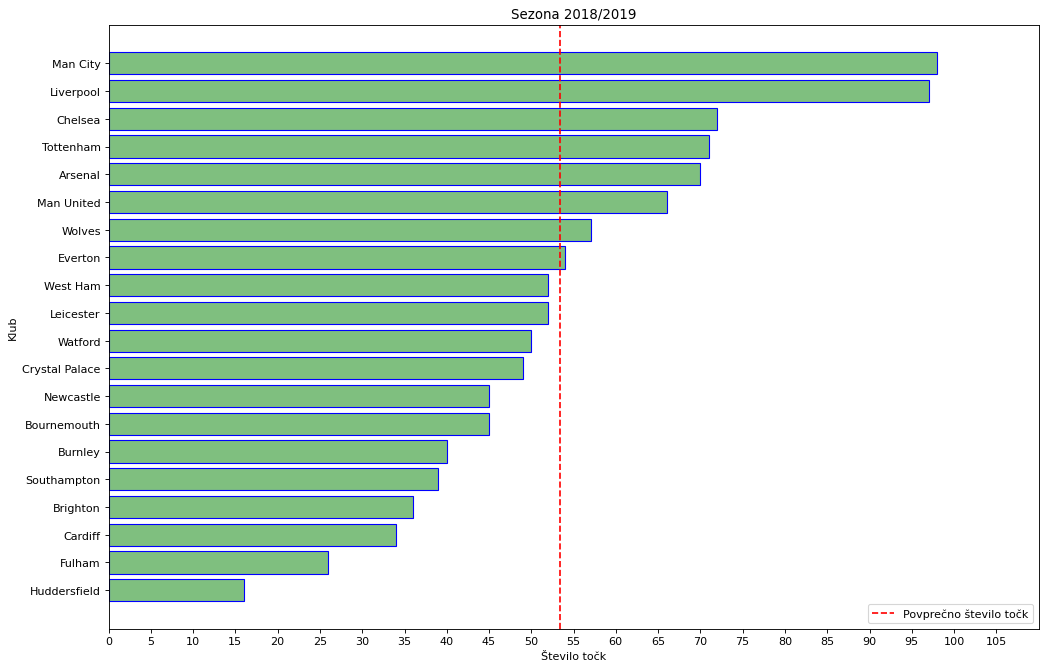

In [6]:
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np
from matplotlib.pyplot import xticks

all_points = []
all_teams = []

for sezona in sezone_teams:
    label_teams = list(sezona.keys())
    all_teams.append(label_teams)
    label_object = sezona.values()
    temp = []
    for team in label_object:
        temp.append(int(team.points))
    all_points.append(temp)

#Prikažemo sam zadnjo sezono
last_season = zip([all_points[-1]], [all_teams[-1]])
    
for p, t in last_season:
    p, t = zip(*sorted([[a,b] for a, b in zip(p, t)], key=lambda item: item[0], reverse=False))
    plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
    xticks(np.arange(0, max(p)+10, step=5))
    
    plt.title("Sezona 2018/2019")
    plt.ylabel("Klub")
    plt.xlabel("Število točk")
    
    plt.barh(t, p,color=(0, 0.5, 0, 0.5), edgecolor='blue')
    plt.axvline(x=np.mean(p), label="Povprečno število točk", c='r', linestyle="--")

    plt.xlim([0,110])
    plt.legend(loc='lower right')

Zgornji graf prikazuje točke klubov v sezoni 2018/2019. Rdeča črtkana črta prikazuje povprečno število točk klubov.

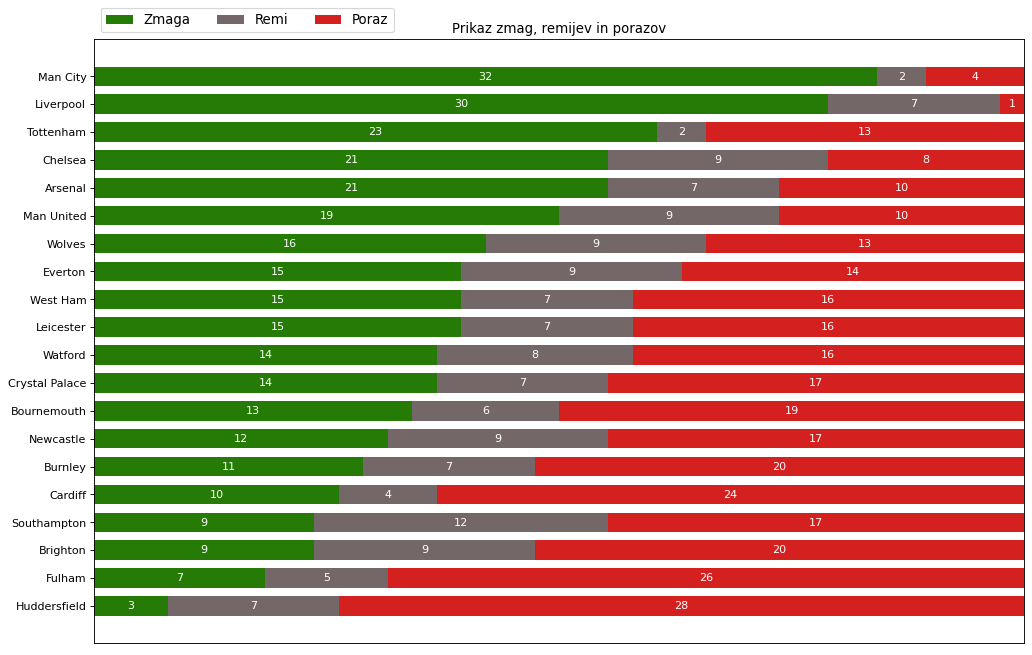

In [7]:
results = defaultdict(list)

for k, v in sezone_teams[-1].items():
    results[k] = [v.win, v.draw, v.loss]
cat = ['Zmaga', 'Remi', 'Poraz']

results = {k:v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=False)}

def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    
    
    plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.title("Prikaz zmag, remijev in porazov")
    xticks([])
    plt.xlim([0,38])

    
    category_colors = [
        [37/255, 123/255, 5/255, 1],
        [116/255, 103/255, 103/255, 1],
        [213/255, 32/255, 32/255, 1]
        
    ]
    
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        plt.barh(labels, widths, left=starts, height=0.7,
                label=colname, color=color)
        xcenters = starts + widths / 2
        r, g, b, _ = color
        text_color = 'white'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            plt.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color)
            plt.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
                  loc='lower left', fontsize='large')

survey(results, cat)
plt.show()

Na zgornjem grafu vidimo kako so ekipe pridobile točke. Opazimo recimo razlike v porazih in remijih med prvima dvema kluboma, kjer je Liverpool imel 3 manj poraze kot Man City a je zaradi velikega števila remijev končal na drugem mestu. <br>
To vidimo tudi na dnu tabele pri primerjavi med Cardiffom in Brightonom, kateri je izpadel iz lige čeprav je imel 4 manj poraze kot Cardiff.

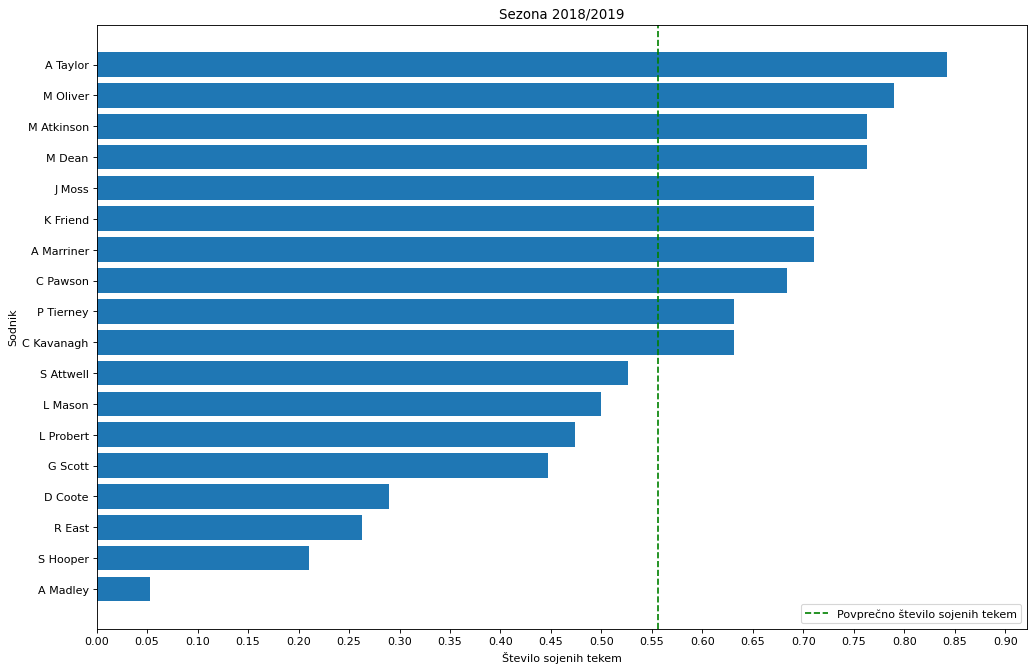

In [8]:

season_labels = ["2016/2017", "2017/2018", "2018/2019"]

last_season = [sezone_referees[-1]]
for i, season in enumerate(last_season):
    season = sorted([(k,v) for k,v in season.items()], key=lambda item: len(item[1].refereed_games),reverse=False)
    sodniki = [k for k,v in season]
    tekme = [len(v.refereed_games)/38 for k,v in season]
    

    
    figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
    


    
    plt.title("Sezona 2018/2019")
    plt.ylabel("Sodnik")
    plt.xlabel("Število sojenih tekem")
    
    plt.barh(sodniki, tekme)
    plt.axvline(x=np.mean(tekme), label="Povprečno število sojenih tekem", c='g', linestyle="--")
    xticks(np.arange(0, 1, step=0.05))
    plt.xlim([0,35/38])
    plt.legend(loc='lower right')
plt.show()
    
    

Zgornji graf prikazuje povprečno število sojenih tekem pri vsakem sodniku. Vidimo da je Anthony Taylor sodil skoraj 0.85 tekme povprečno na teden, torej je sodil skoraj vsak teden.<br>
Vidimo tudi da povprečni sodnik sodi vsaki drugi teden, torej eno tekmo na dva tedna.<br> 
Iz tega lahko sklepamo, kateri sodniki so najbolj izkušeni ter morda tudi najbolj utrujeni. 

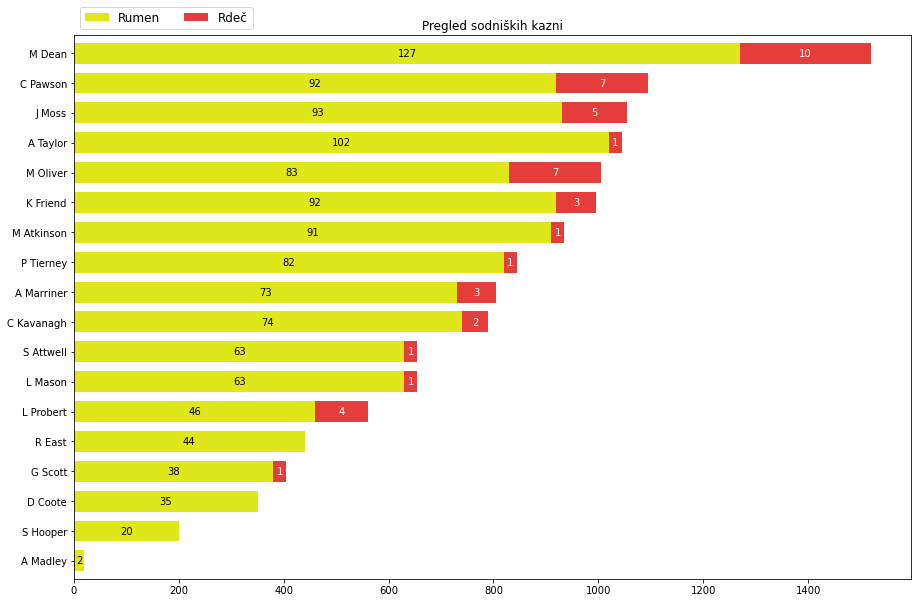

In [9]:
season_labels = ["2016/2017", "2017/2018", "2018/2019"]

last_season = [sezone_referees[-1]]
for i, season in enumerate(last_season):
    season = sorted([(k,v) for k,v in season.items()], key=lambda item: item[1].booking_points,reverse=False)
    sodniki = [k for k,v in season]
        
    kartoni = [v.booking_points for k,v in season]
        
    fig, ax = plt.subplots(facecolor='white', figsize=(15,10), edgecolor='k')
    
    
    width = 0.9
    
    yellows = [v.get_cards()[0]*10 for k, v in season]
    red = [v.get_cards()[1]*25 for k, v in season]
        
    category_colors = [
        [223/255, 230/255, 25/255, 1],
        [229/255, 60/255, 60/255, 1]
    ]    
        
    
    df0 = pd.DataFrame({'Rumen':yellows,'Rdeč':red}, columns=['Rumen', 'Rdeč'],
                       index=sodniki)
    df0.plot.barh(ax=ax, stacked=True, color=category_colors, width=0.7)
    
    plt.title("Pregled sodniških kazni")
    plt.legend(ncol=2, bbox_to_anchor=(0, 1),
                  loc='lower left', fontsize='large')
    
    
    for y, (yellow, redC) in enumerate(zip(yellows, red)):        
        ax.text(yellow/2, y, str(int(yellow/10)), ha='center', va='center',
                    color='black')
        if redC > 0:
             ax.text(yellow + redC/2, y, str(int(redC/25)), ha='center', va='center',
                     color='white')     
                
    
plt.show()

Števila na x osi nam povejo kakšen je izračun skupnih kazni kjer so rumeni kartoni vredni 10 točk in rdeči 25.

dict_items([('365', 673.2400000000005), ('IW', 629.3900000000003), ('BW', 641.6)])


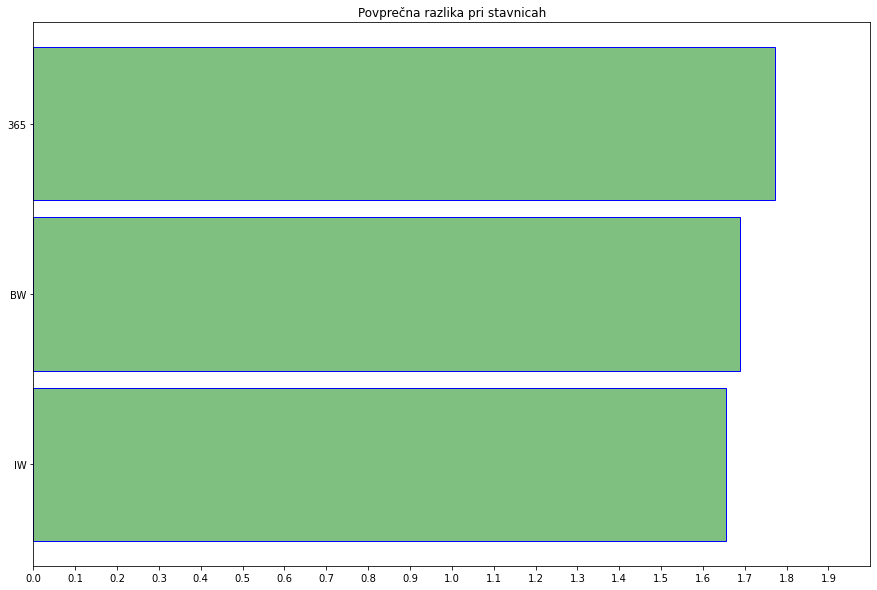

In [10]:
print(betting_sites.items())
sites = [k for k,v in sorted(betting_sites.items(), key=lambda item:item[1], reverse=False)]
sums = [v/380 for k,v in sorted(betting_sites.items(), key=lambda item:item[1], reverse=False)]
fig, ax = plt.subplots(facecolor='white', figsize=(15,10), edgecolor='k')
plt.title("Povprečna razlika pri stavnicah")
plt.barh(sites, sums,color=(0, 0.5, 0, 0.5), edgecolor='blue', height=0.9)

xticks(np.arange(0, max(sums)+0.2, step=0.1))
_=plt.xlim([0,2])
    
    


Graf prikazuje kako pravilno so stavnice napovedovale rezultate skozi sezono 2018/2019. Vrednost na x predstavlja povprečen seštevek razlik pri vsaki tekmi, npr. stavnica 365 je za tekmo predstavila naslednje kvote: H:2.4, A:3.25, D:3.3, rezultat pa je bil izenačen, torej smo 365 prišteli razliko 3.3 - 1, kjer 1 pomeni pravilno napovedan rezultat. <br>
Graf predstavlja povprečje teh vrednosti, katere nam npr. povejo kje se najbolj splača stavit in katera stavnica se je najbolj približala dejanskim rezultatom.

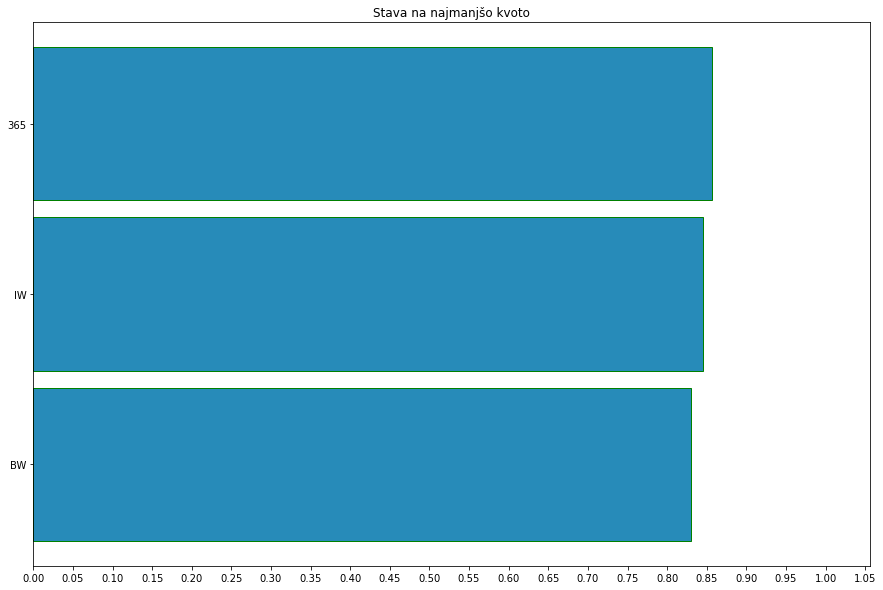

In [11]:
sites = [k for k,v in sorted(i_bet.items(), key=lambda item:item[1], reverse=False)]
sums = [(v)/380 for k,v in sorted(i_bet.items(), key=lambda item:item[1], reverse=False)]
fig, ax = plt.subplots(facecolor='white', figsize=(15,10), edgecolor='k')
plt.title("Stava na najmanjšo kvoto")
plt.barh(sites, sums,color=(39/255, 139/255, 185/255, 1), edgecolor='green', height=0.9)

xticks(np.arange(0, max(sums)+0.2, step=0.05))
_=plt.xlim([0,max(sums)+0.2])
    
    


Graf nam pove koliko bi zaslužili če bi zmeraj stavili na ekipo z najmanjšo kvoto, torej favorita v očeh stavnice. Kot vidimo na x osi, so vse vrednosti manjše od 1, torej bi denar dejansko izgubili. 

In [12]:
all_fouls = dict()
all_cards = dict()
last_season = [sezone_referees[-1]]
for i, season in enumerate(last_season):
    season = sorted([(k,v) for k,v in season.items()], key=lambda item: len(item[1].refereed_games),reverse=False)
    for k, referee in season:
        for match in referee.refereed_games:
            home = match.home_team
            home_fouls = int(match.hf)
            away = match.away_team
            away_fouls = int(match.af)
            
            home_yellow = int(match.hy)
            home_red = int(match.hr)
            away_yellow = int(match.ay)
            away_red = int(match.ar)
            
            if home not in all_cards:
                all_cards[home] = [home_yellow,home_red]
            else:
                all_cards[home][0] += home_yellow
                all_cards[home][1] += home_red
            
            if away not in all_fouls:
                all_cards[away] = [away_yellow,away_red]
                
            else:
                all_cards[away][0] += away_yellow
                all_cards[away][1] += away_red
            

            if home not in all_fouls:
                all_fouls[home] = [home_fouls,0]
            else:
                all_fouls[home][0] += home_fouls
            
            if away not in all_fouls:
                all_fouls[away] = [0,away_fouls]
                
            else:
                all_fouls[away][1] += away_fouls


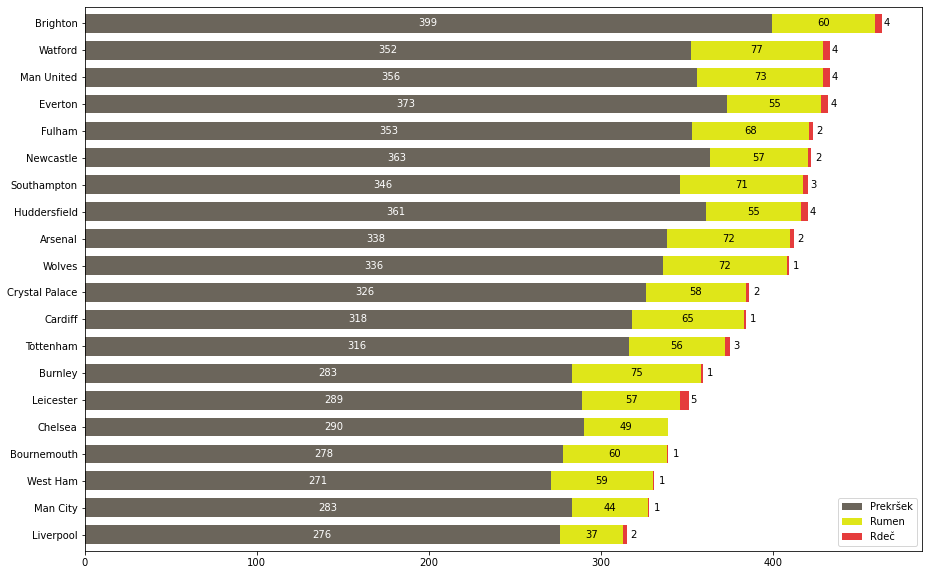

In [13]:
labels = list(all_fouls.keys())
f = list(all_fouls.values())
new_f = []

for i,j in f:
    new_f.append(i+j)

labels = [x for _,x in sorted(zip(new_f,labels))]
new_f = sorted(new_f)

wry = []
yellows = []
red = []
for l, f in zip(labels,new_f):
    yellows.append(all_cards[l][0])
    red.append(all_cards[l][1])
    
    f = f - all_cards[l][0] - all_cards[l][1]
    wry.append(f)


    
    
category_colors = [
        [107/255, 101/255, 91/255, 1],
        [223/255, 230/255, 25/255, 1],
        [229/255, 60/255, 60/255, 1]
]    
        
fig, ax = plt.subplots(facecolor='white', figsize=(15,10), edgecolor='k')    
df0 = pd.DataFrame({'Prekršek':wry,'Rumen':yellows,'Rdeč':red}, columns=['Prekršek','Rumen', 'Rdeč'],
                       index=labels)
df0.plot.barh(ax=ax, stacked=True, color=category_colors, width=0.7)    

for y, (p, yellow, redC) in enumerate(zip(wry, yellows, red)):      
    #print(p, yellow, redC)
    ax.text(p/2, y, str(int(p)), ha='center', va='center',
    color='white')
    
    ax.text(p+ yellow/2, y, str(int(yellow)), ha='center', va='center',
    color='black')
    if redC > 0:
        ax.text( p + yellow + redC/2 + 5, y, str(int(redC)), ha='center', va='center',
        color='black')     
                
    
#fig, ax = plt.subplots(facecolor='white', figsize=(15,10), edgecolor='k')
#plt.barh(labels,wry)  

plt.show()

Graf prikazuje število storjenih prekrškov za vsak klub, ter kolikšen del teh prekrškov je bil kaznovan z rumenim ter rdečim. 

Graf nam da približno idejo o filozofiji igre v posameznih klubih. Lahko rečemo, da klubi ki so v nižji polovici (Liverpool, Man City, Chelsea) igrajo posestno igro, torej igrajo na to da držijo žogo pri sebi skozi večino tekme. To tudi pomeni, da bodo težje storili prekršek če nasprotnik nima žogo v posesti. Mogoče je tudi, da so ekipe premalo agresivne, kar je pogosto pri ekipah, ki se borijo za obstanek. <br>

Ekipe, ki so v zgornjem delu tega grafa so ekipe, ki igrajo predvsem agresivno igro, ki temelji na razbijanju nasprotnikove igre prej kot nasprotnikova akcija dejansko postane nevarna. Taka filozofija je zelo pogosta pri klubih v angleški ligi, je pa zelo zahtevna za igralce, saj morajo biti fizično v zelo dobri formi skozi sezono.

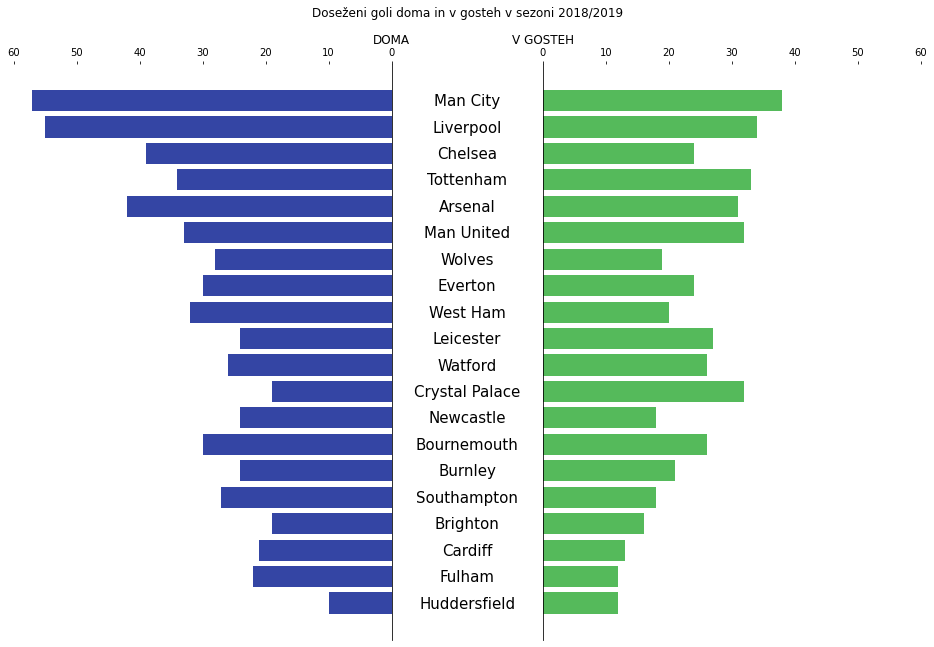

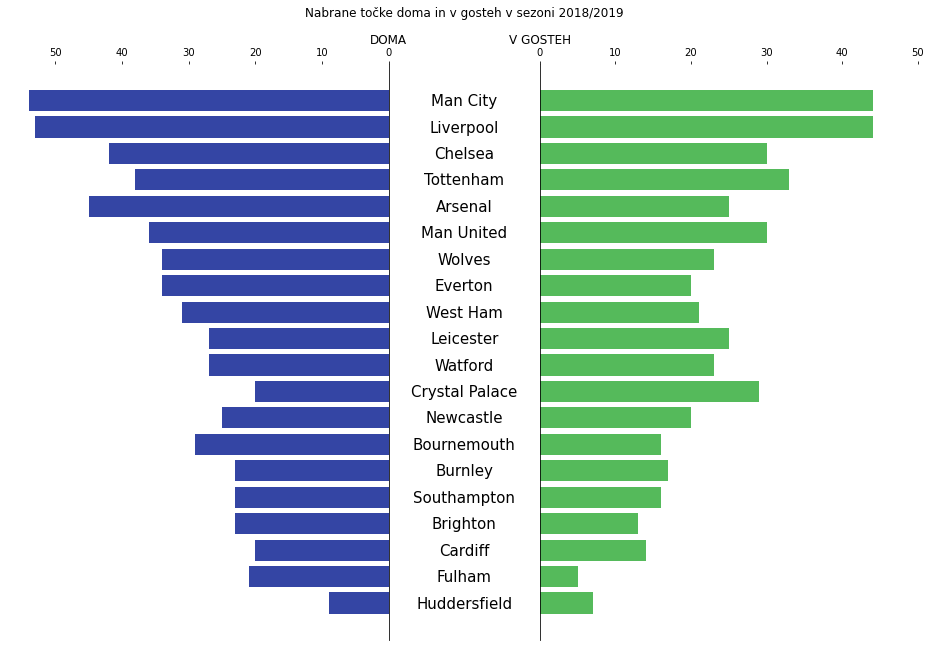

In [14]:
def tornadoPlot(year, home, away, clubs, title):
    num_spans = len(clubs)
    pos = np.arange(num_spans) + .5
    fig = plt.figure(figsize=(15, 10), facecolor='white', edgecolor='none')

    titles = {"points": f"Nabrane točke doma in v gosteh v sezoni {year}/{year + 1}", "goals": f"Doseženi goli doma in v gosteh v sezoni {year}/{year + 1}"}

    fig.suptitle(titles[title])

    ax_home = fig.add_axes([0.08, 0.1, 0.35, 0.8])
    ax_away = fig.add_axes([0.57, 0.1, 0.35, 0.8])

    for loc, spine in ax_home.spines.items():
        if loc != 'right':
            spine.set_color('none')  # don't draw spine

    for loc, spine in ax_away.spines.items():
        if loc != 'left':
            spine.set_color('none')  # don't draw spine 

    ax_home.xaxis.set_ticks_position('top')
    ax_away.xaxis.set_ticks_position('top')

    ax_home.barh(pos, home, align='center', facecolor='#3445a4', edgecolor='None')
    ax_home.set_yticks([])
    ax_home.invert_xaxis()
    ax_home.xaxis.set_ticks(np.arange(0, max(max(away), max(home)) + 5, step=10))

    ax_away.barh(pos, away, align='center', facecolor='#55ba5b',
                edgecolor='None')
    ax_away.set_yticks([])
    ax_away.xaxis.set_ticks(np.arange(0, max(max(away), max(home)) + 5, step=10))

    import matplotlib.transforms as transforms
    transform = transforms.blended_transform_factory(
        fig.transFigure, ax_away.transData)
    for i, label in enumerate(clubs):
        ax_away.text(0.5, i + 0.5, label, size=15, ha='center', va='center',
                    transform=transform)

    ax_away.set_title('V GOSTEH', x=0.0, y=1.025, fontsize=12)
    ax_home.set_title('DOMA', x=1.0, y=1.025, fontsize=12)

    plt.show()


temp = sorted([(k,v.home_goals, v.away_goals, v.home_points, v.away_points) for k,v in teams.items()], key=lambda item: teams[item[0]].points,reverse=False)    
home_goals = [thg for _, thg, _,_,_ in temp]
away_goals = [tag for _, _, tag,_,_ in temp]
home_points = [thg for _, _, _,thg,_ in temp]
away_points = [tag for _, _, _,_,tag in temp]
clubs = [team for team, _, _, _, _ in temp]
tornadoPlot(2018, home_goals, away_goals, clubs, "goals")
tornadoPlot(2018, home_points, away_points, clubs, "points")

Zgornja dva grafa opisujeta kako domači stadion vpliva na igro ekip. Domači teren bi v teoriji moral zmeraj prevagati igro v gosteh, sploh v največjih ligah, zaradi človeške psihologije.

Na zgornjem grafu vidimo kako so ekipe izkoristile domači teren za dosegovanje zadetkov. Kot pričakovano je večini ekip udobneje igrati na domačem terenu, kjer imajo prednost v navijačih. Vidimo pa da so nekatere izjeme, kot so Crystal Palace ter Leicester, kateri so v gosteh dosegli več ali enako zadetkov kot doma. <br> <br>
Spodnji graf podobno prikazuje kako so ekipe izkoristile domači teren vendar tokrat za zmage na tekmah. Kot na zgornjem grafu je pričakovano da ekipa več tekem zmaga doma, kar tudi vidimo v podobnosti z prvim grafom. <br> <br>
Vseeno pa vidimo razlike sploh na vrhu lestvice, kjer sta Liverpool in Man City dosegla zelo veliko točk v gosteh, čeprav njuno število golov ne odstopa preveč od drugih ekip. Iz tega lahko sklepamo, da imata obe ekipi zelo dobro obrambo. 

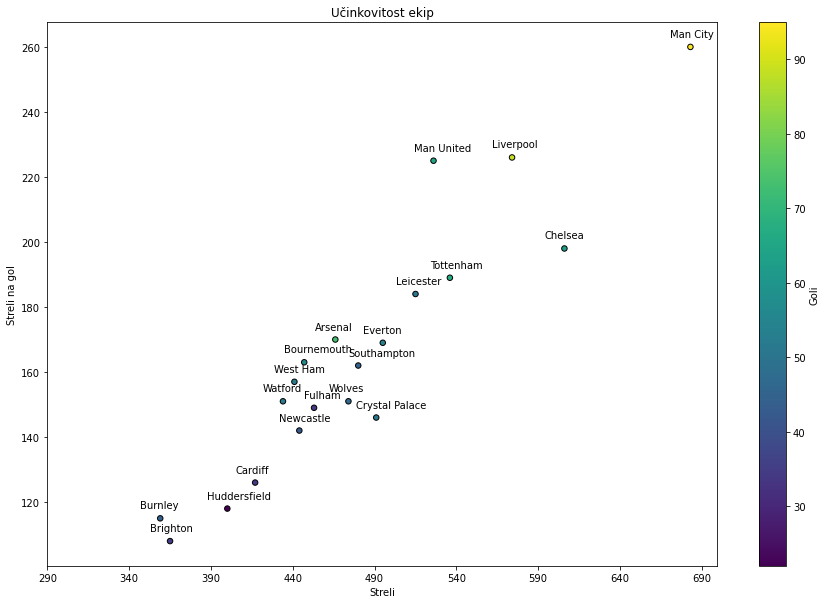

In [15]:
HSTG = []
temp = sorted([(k,v) for k,v in teams.items()], key=lambda item: teams[item[0]].points,reverse=True)    

#for k,v in teams.items():
for k,v in temp:
    HSTG.append([v.home_shots + v.away_shots, v.home_shots_on_target 
    + v.away_shots_on_target, v.home_goals + v.away_goals])

fig, ax = plt.subplots(facecolor='white', figsize=(15,10), edgecolor='k')    
df = pd.DataFrame(HSTG, columns =["Streli", "Streli na gol", "Goli"])
df.plot.scatter(ax=ax, figsize=(15,10),s=30,x="Streli", y="Streli na gol", c="Goli", facecolor='w', 
                     edgecolor='k', colormap="viridis",sharex=False)
_=ax.set_xticks(np.arange(290, 710, step=50)) 
ax.set_title("Učinkovitost ekip")

clubs = [k for k,v in temp][:20]
for i, txt in enumerate(clubs):
    if txt in ["Southampton", "Fulham"]:
        ax.annotate(txt, (HSTG[i][0], HSTG[i][1]), xytext=(-10,10), textcoords='offset points', fontsize="10")    
    else:
        ax.annotate(txt, (HSTG[i][0], HSTG[i][1]), xytext=(-20,10), textcoords='offset points', fontsize="10")


Graf prikazuje kako natančne so ekipe v strelih. Vidimo kako dominanten je Manchester City v svoji igri, saj ima precejšno prednost v strelih ter strelih na gol pred naslednjim zasledovalcem. <br>
Ekipe z največjim razmerjem med streli na gol in streli bodo tipično bolj uspešne, kar je tudi opazno na tem grafu, saj vidimo da obstaja močna korelacija med streli na gol, streli ter številom zadetkov. <br> Vidimo lahko tudi razliko v učinkovitosti med Manchester City-om ter Liverpool-om, saj imata pri podobnem številu zadetkov precej različno razmerje v strelih. 


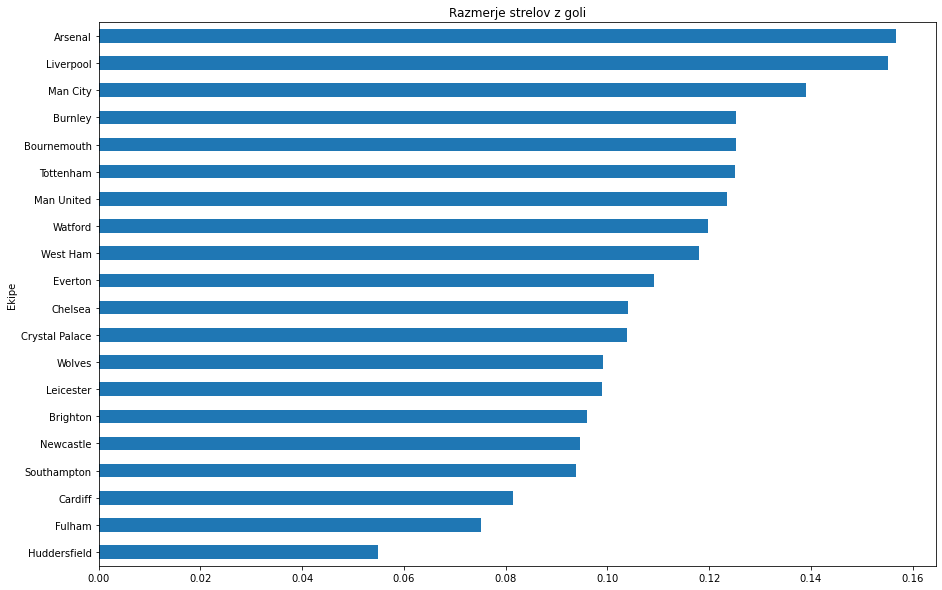

In [16]:
HSTG = []
temp = sorted([(k,v) for k,v in teams.items()], key=lambda item: teams[item[0]].points,reverse=True)    


for k,v in temp:
    ratio = (v.home_goals + v.away_goals) / (v.home_shots + v.away_shots)
    HSTG.append(ratio)


clubs = [k for k,v in temp]
ratios = sorted([(team, rat) for team, rat in zip(clubs, HSTG)], key=lambda item: item[1], reverse=False)

fig, ax = plt.subplots(facecolor='white', figsize=(15,10), edgecolor='k')    
df = pd.DataFrame({'Ekipe':[k for k,v in ratios], 'Ratio':[v for k,v in ratios]})
_=df.plot.barh(ax=ax, x='Ekipe', y='Ratio', legend=None)  
_=ax.set_title("Razmerje strelov z goli")



Graf je podoben prejšnjemu vendar ta kaže učinkovitost strelov ekip glede na dosežene gole. Vidimo da je na vrhu Arsenal, ki z razmerjem 0.15 gola na strel doseže gol skoraj vsaki sedmi strel. Kot pa smo videli na prejšnjih grafih, to ne pomeni, da je ekipa uspešna, saj je Arsenal šele na petem mestu po številu točk. <br> <br>
Iz tega lahko sklepamo da imajo ekipe kot so Arsenal bodisi premalo strelov na gol, kar vidimo na prejšnjem grafu, bodisi preslabo obrambno igro, kar največkrat velja za ekipe v spodnji polovici lestvice, kot je npr. Burnley, ki na tem grafu zaseda četrto mesto, po točkah je pa na 14. mestu.

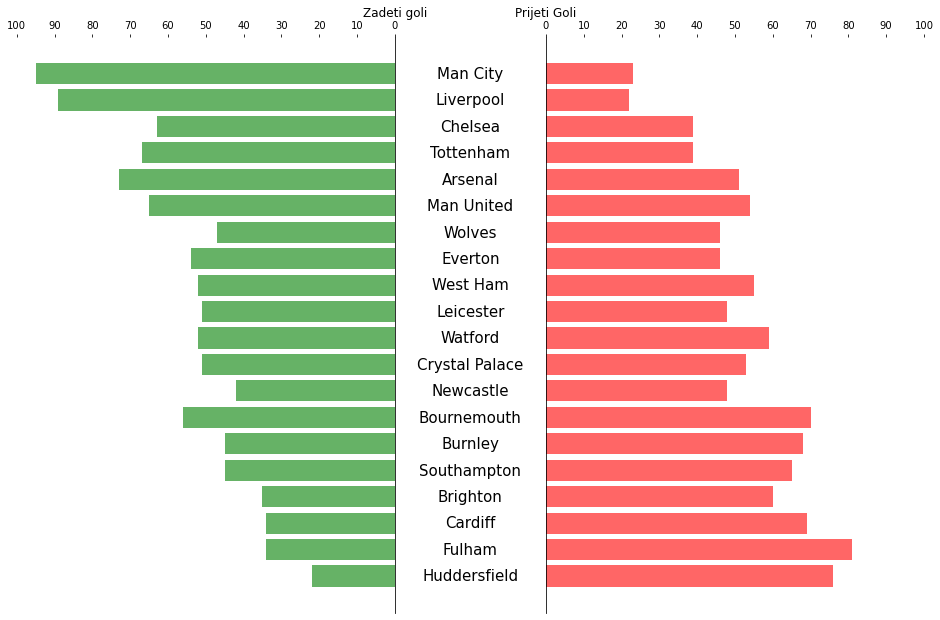

In [17]:
temp = sorted([(k,v.goals_conceded, v.goals_scored) for k,v in teams.items()], key=lambda item: teams[item[0]].points,reverse=False) 
clubs = [team for team, _, _, in temp]
num_spans = len(clubs)
pos = np.arange(num_spans) + .5
fig = plt.figure(figsize=(15, 10), facecolor='white', edgecolor='none')
taken = [thg for  _,thg,_ in temp]
given = [tag for _,_,tag in temp]
title = "Title placeholder"


ax_given = fig.add_axes([0.08, 0.1, 0.35, 0.8])
ax_taken = fig.add_axes([0.57, 0.1, 0.35, 0.8])

for loc, spine in ax_given.spines.items():
    if loc != 'right':
        spine.set_color('none')  # don't draw spine

for loc, spine in ax_taken.spines.items():
    if loc != 'left':
        spine.set_color('none')  # don't draw spine 

ax_given.xaxis.set_ticks_position('top')
ax_taken.xaxis.set_ticks_position('top')

ax_given.barh(pos, given, align='center', facecolor='green', alpha=0.6, edgecolor='None')
ax_given.set_yticks([])
ax_given.invert_xaxis()
ax_given.xaxis.set_ticks(np.arange(0,max(max(taken), max(given)+10), step=10))

ax_taken.barh(pos,taken, align='center', facecolor='red', alpha=0.6,
                edgecolor='None')
ax_taken.set_yticks([])
ax_taken.xaxis.set_ticks(np.arange(0, max(max(taken), max(given)+10), step=10))

import matplotlib.transforms as transforms
transform = transforms.blended_transform_factory(
fig.transFigure, ax_taken.transData)
for i, label in enumerate(clubs):
    ax_taken.text(0.5, i + 0.5, label, size=15, ha='center', va='center',
                    transform=transform)

ax_given.set_title('Zadeti goli', x=1.0, y=1.025, fontsize=12)
ax_taken.set_title('Prijeti Goli', x=0, y=1.025, fontsize=12)

plt.show()
_=fig.suptitle(title)

Zgornji graf dopolnjuje prejšnjega, saj nam v bistvu pokaže kako dobra je obrambna igra posameznih klubov. Kot prej omenjeno je Burnley dokaj visoko na zgornjem grafu z svojo učinkovitostjo pri strelih. Spodnji graf nam pa pove, da kot pričakovano je njihova obramba precej slaba, saj so v sezoni 38 tekem prejeli skoraj 70 zadetkov. 

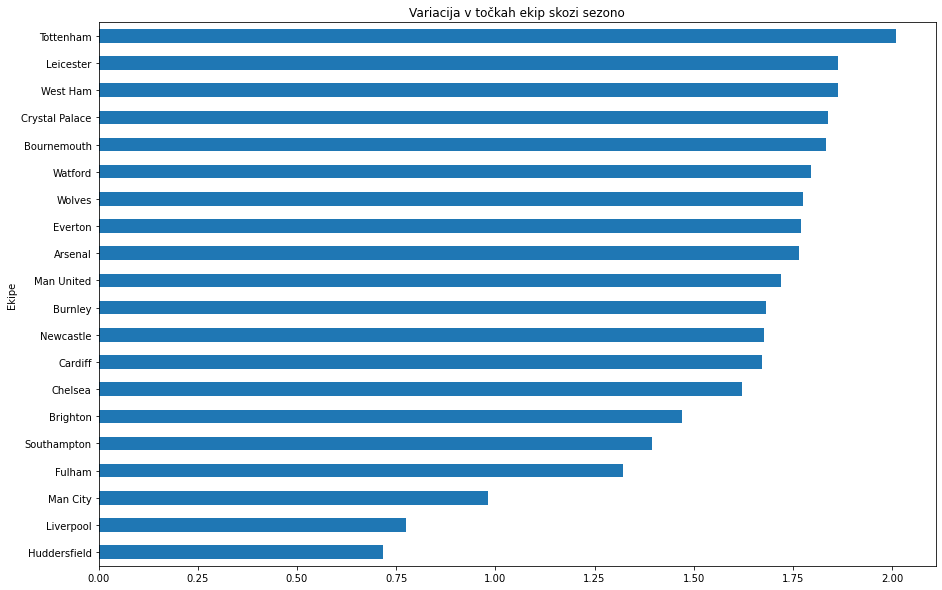

In [18]:
team_vars = defaultdict(list)
for name, team in teams.items():
    avg_points = team.points/38
    temp = []
    for match in team.played_games:
        if (name == match.home_team and match.ftr == "H") or (name == match.away_team and match.ftr == "A"):
            temp.append(3)
            #print("WIN")
        elif match.ftr == "D":
            temp.append(1)
            #print("DRAW")
        else:
            temp.append(0)
            #print("LOSS")        
    team_vars[name] = temp
    #print(np.var(temp))
for team, var in team_vars.items():
    pass
    #print(team, var)

team_vars = {k:v for k, v in sorted(team_vars.items(), key=lambda item: np.var(item[1]))}

fig, ax = plt.subplots(facecolor='white', figsize=(15,10), edgecolor='k')    
df = pd.DataFrame({'Ekipe':[k for k, v in team_vars.items()], 'Variacije':[np.var(v) for k, v in team_vars.items()]})
_=df.plot.barh(ax=ax, x='Ekipe', y='Variacije', legend=None)  
_=ax.set_title("Variacija v točkah ekip skozi sezono")    


Variacija v točkah nam pove, kako konsistentno so ekipe skozi sezono pridobivale točke. Izračuna se kot vsota razlik med točkami vsako tekmo in povprečnimi točkami na tekmo. Klubi, ki pogosto zmagujejo tekme (Liverpool) ali pa tudi pogosto izgubljajo tekme (Huddersfield) imajo manjšo variacijo v točkah. Klubi z večjo variacjo imajo precej bolj nekonsistentne rezultate kot lahko vidimo na naslednjih grafih.

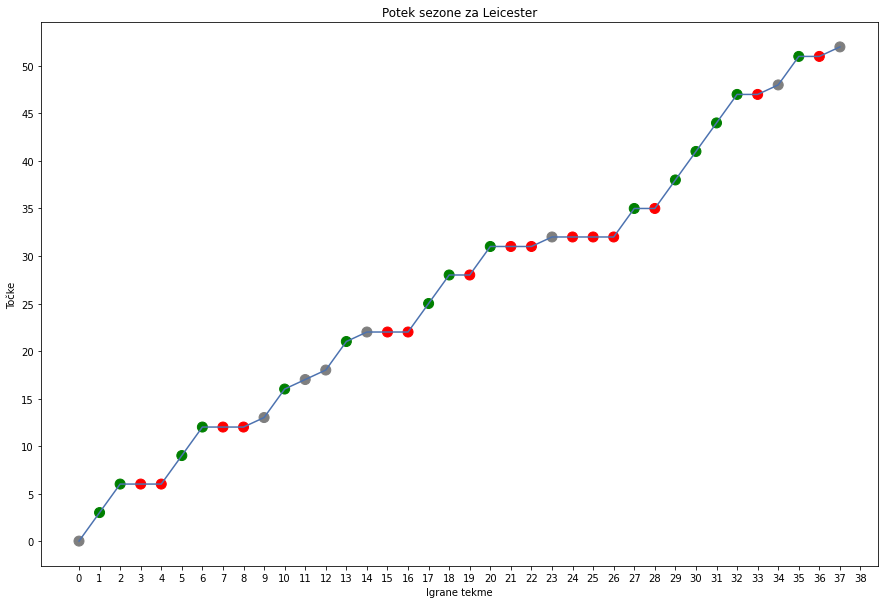

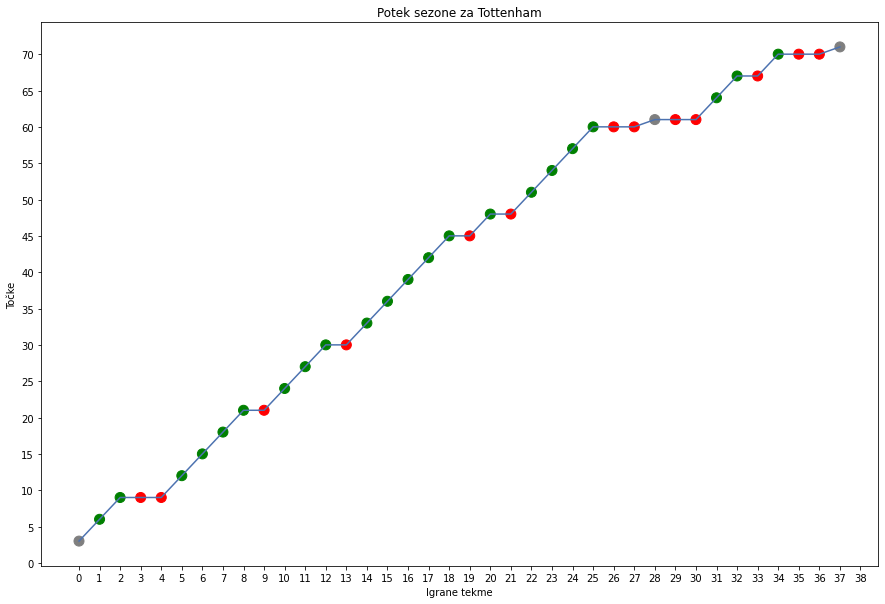

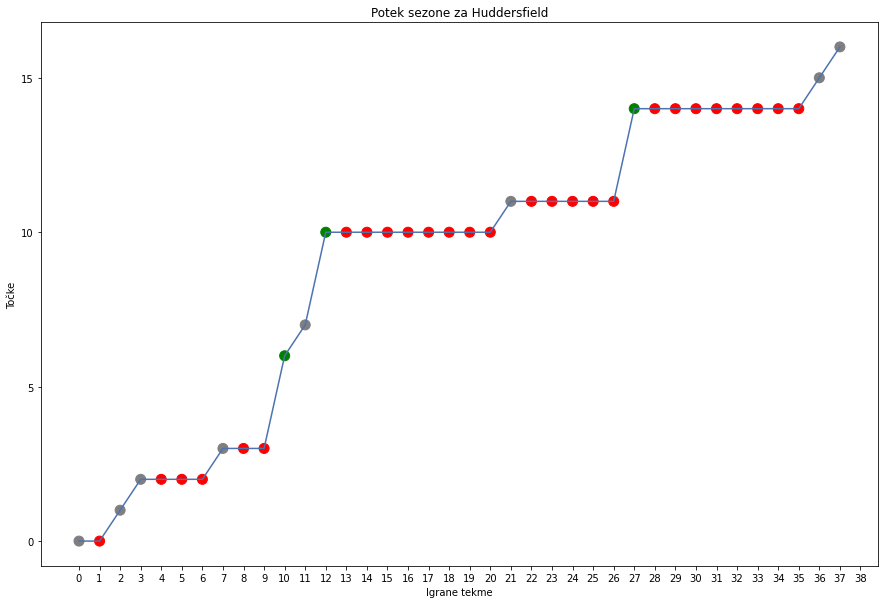

In [19]:
plt.style.use('seaborn-deep')
def get_colors(team):
    gamesCum = np.cumsum(team_vars[team])
    colors = []
    for i, points in enumerate(gamesCum):
        if i == 0:
            colors.append("tab:gray")
        elif points - gamesCum[i-1] == 3:
            colors.append("g")
        elif points - gamesCum[i-1] == 0:
            colors.append("r")
        elif points - gamesCum[i-1] == 1:
            colors.append("tab:gray")
    return colors

def season_chart(team1):
    games = team_vars[team1]
    gamesCum = np.cumsum(games)
    
    colors = get_colors(team1)
    
    fig, ax = plt.subplots(facecolor='white', figsize=(15,10), edgecolor='k')    
    df = pd.DataFrame({"Točke": gamesCum, "Igrane tekme": np.arange(0, 38, step=1)})
    _=ax.set_xticks(np.arange(0, 39, step=1)) 
    _=df.plot.line(ax=ax, y="Točke", x="Igrane tekme",markerfacecolor='green', yticks = range(0,max(gamesCum)+6,5), legend=False)
    
    df1 = pd.DataFrame({"Igrane tekme": np.arange(0, 38, step=1), "Točke": gamesCum, "color" : colors})
    df1.plot.scatter(ax=ax, x="Igrane tekme", y= "Točke", s=100, c = df1["color"])
    _=ax.set_title(f"Potek sezone za {team1}")    



season_chart('Leicester')
season_chart('Tottenham')
season_chart("Huddersfield")


Na prvih dveh grafih vidimo kluba z največji variacijo v točkah. Vidimo, da je imel Tottenham zelo dobro, konsistentno prvo polovico sezone, v kateri se je tudi boril za mesto med prvima dvema na lestvici. V drugi polovici so pa zaradi različnih razlogov popustili ter izgubili precej tekem, zaradi česar jim variacija tako zelo zraste. <br> <br> Huddersfield je pa na drugi strani, z najnižjo variacijo, imel zelo slabo sezono ter je nizal poraz za porazom. Z številom točk so v tej sezoni pristali na tretjem mestu med ekipami z najnižjim številom točk v zgodovini angleški premier lige ob koncu sezone.


In [20]:
gameweeks = defaultdict(dict)
for i in range(0, 38):
    temp = defaultdict(int)
    for club, obj in teams.items():
        match = obj.played_games[i]
        if match.winner == match.loser:
            temp[club] += 1
        elif match.winner == club:
            temp[club] += 3
        else:
            temp[club] += 0
    gameweeks[i] = temp


for week, games in gameweeks.items():
    for club, points in games.items():
        if week > 0:
            games[club] += gameweeks[week-1][club]

    
for week, games in gameweeks.items():
    gameweeks[week] = {k:v for k, v in sorted([(k,v) for k,v in gameweeks[week].items()], key=lambda item: item[1], reverse=True)}

    
season = []
for week, games in gameweeks.items():
    weekG = []
    #print(games)
    for k, i in zip(games.keys(), range(0,6)):
        weekG.append([i+1, k, week+1, games[k]])
    if weekG != []:
        season.append(weekG)
#print(season)


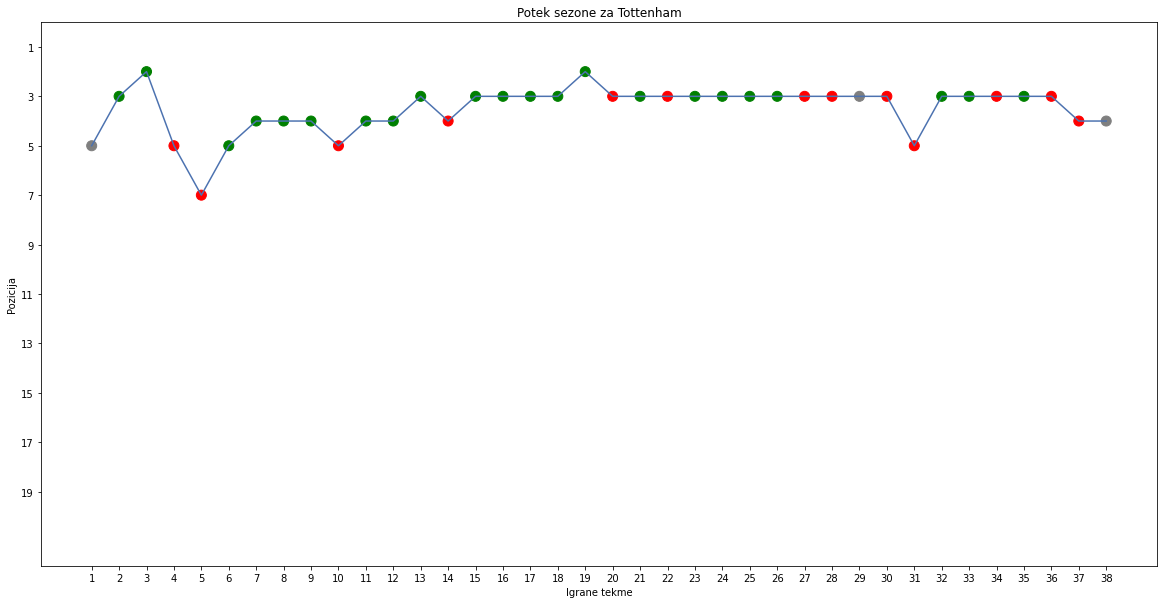

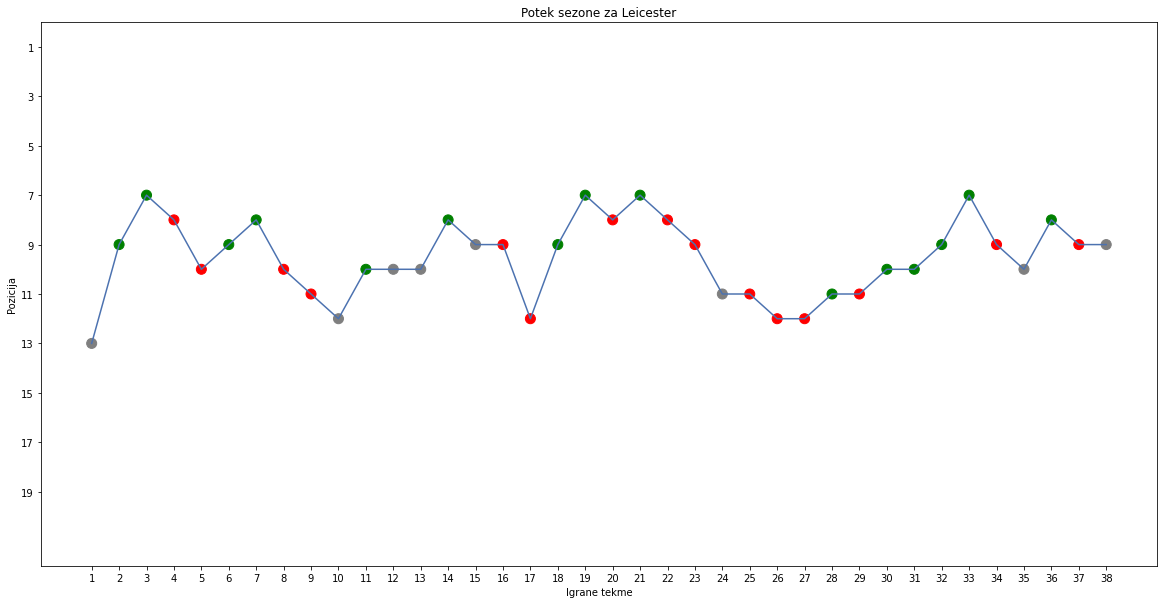

In [21]:

def season_placement_chart(team):
    places = []
    for week, games in gameweeks.items():
        for i, k in enumerate(games.keys()):
            #print(i, k, games[k])
            if k == team:
                places.append(i+1)
                
    fig, ax = plt.subplots(facecolor='white', figsize=(20,10), edgecolor='k')    
    df = pd.DataFrame({"Mesto": places, "Igrane tekme": np.arange(1, 39, step=1)})
    _=ax.set_xticks(np.arange(1, 39, step=1)) 
    _=ax.set_yticks(np.arange(1, 21, step=2)) 

    _=df.plot.line(ax=ax, y="Mesto", x="Igrane tekme",markerfacecolor='green', ylim=(0, 22), legend=False)
    fig.gca().invert_yaxis()
    colors = get_colors(team)
    
    
    df1 = pd.DataFrame({"Igrane tekme": np.arange(1, 39, step=1), "Pozicija": places, "color" : colors})
    df1.plot.scatter(ax=ax, x="Igrane tekme", y= "Pozicija", s=100, c = df1["color"])
    _=ax.set_title(f"Potek sezone za {team}")    
    
    #print(places)
    
season_placement_chart("Tottenham")    
season_placement_chart("Leicester")

Podobna zgornjim grafom, ta grafa namesto pridobljenih točk prikazujeta pozicijo kluba na lestvici skozi sezono. Kot omenjeno prej je Tottenham z zelo dobrim začetkom konkuriral za prvo mesto, vendar z svojimi porazi ni bil kos Manchester City-u in Liverpool-u, kar od Tottenham-a tudi noben ni pričakoval, glede na to da sta oba imela božansko sezono. <br>
Medtem pa je Leicester bil bitko na sredini lestvice. Vidimo, da je bil konsistentno med 13. mestom ter v najboljšem delu tudi na 6. mestu na lestvici, ampak je zaradi preveč porazov na koncu tudi ostal na sredini na 9. mestu. 

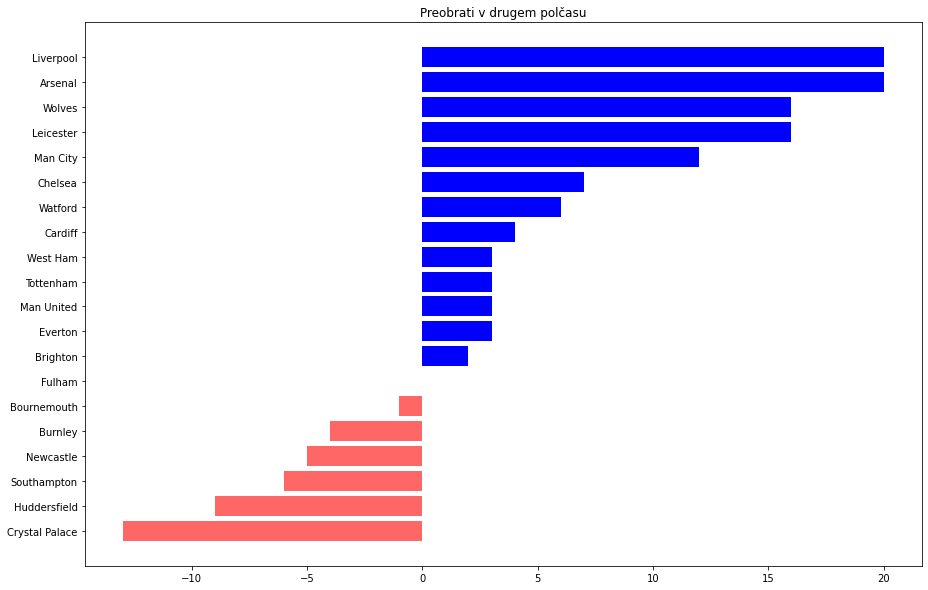

In [22]:
pos_val = []
neg_val = []
neg_labels = []
pos_labels = []
for k,v in teams.items():
    val = v.points - v.half_time_points
    if val >= 0:
        pos_val.append(val)
        pos_labels.append(k)
    else:
        neg_val.append(val)
        neg_labels.append(k)

        
pos_labels = [x for _,x in sorted(zip(pos_val,pos_labels))]
pos_val = sorted(pos_val)      

neg_labels = [x for _,x in sorted(zip(neg_val,neg_labels))]
neg_val = sorted(neg_val)  
               
    
#ax_taken.barh(pos,taken, align='center', facecolor='red', alpha=0.6,
#                edgecolor='None')

fig, ax = plt.subplots(facecolor='white', figsize=(15,10), edgecolor='k')  

ax.barh(neg_labels, neg_val, facecolor='red', alpha=0.6,
                edgecolor='None')
_=ax.barh(pos_labels, pos_val, color='b')
_=ax.set_title(f"Preobrati v drugem polčasu")

Na zgornjem grafu vidimo, kako odporne so ekipe povprečno v drugem polčasu. Vrednost na x osi prikazuje razliko med vsemi točkami, ki jih ima ekipa ter točkami, ki jih je ekipa imela ob polčasu. <br> <br>
Ekipe, ki so skrajno na vrhu tega grafa, npr. Liverpool, Arsenal, v drugem polčasu igrajo bolje kot v prvem, saj so si v drugem polčasu priborile 20 točk, torej so iz poraznega rezultata ob polčasu preobrnali igro ter zmagali ali remizirali ob koncu igre.  <br><br>
Ekipe na dnu tega grafa, v prvem polčasu igrajo bolje kot v drugem ter zato v drugem polčasu izgubijo precej točk. Razlogov za to je več, najbolj očitni so da jim pade koncentracija ter verjetno nimajo igralcev, ki bi lahko celo igro zadržali zmagujoči rezultat. 

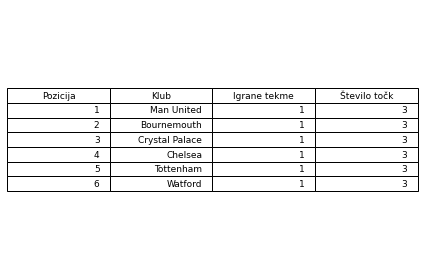

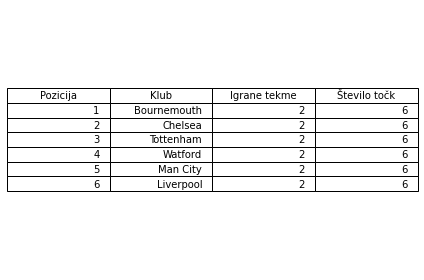

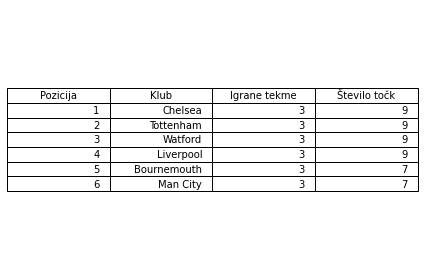

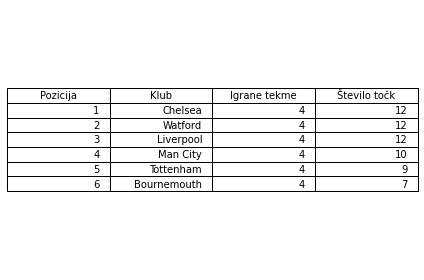

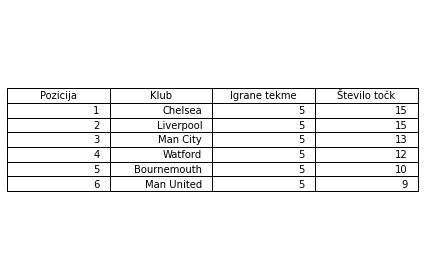

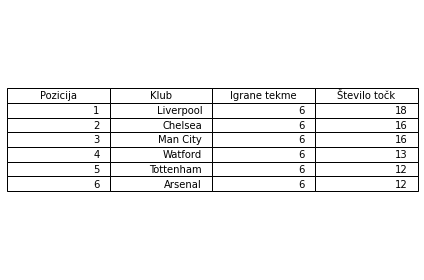

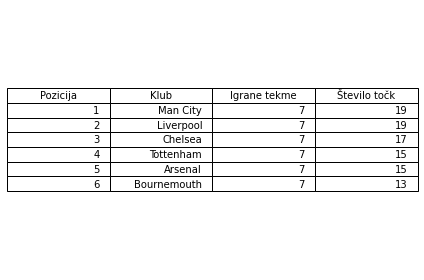

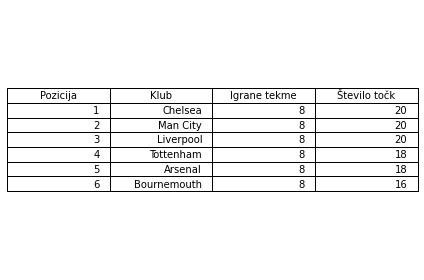

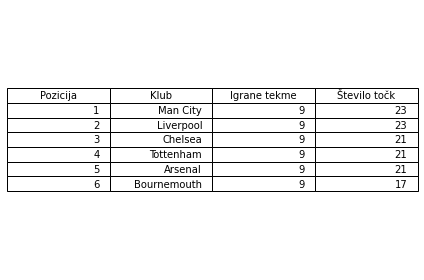

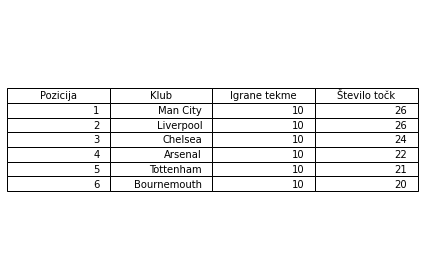

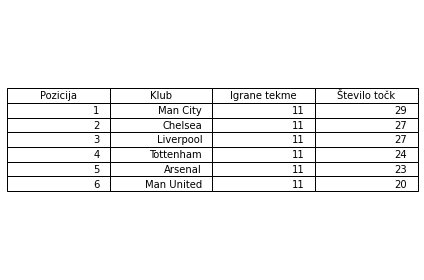

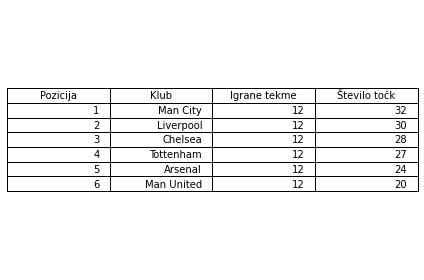

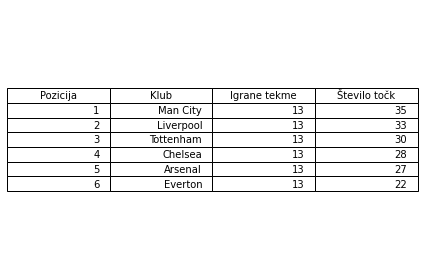

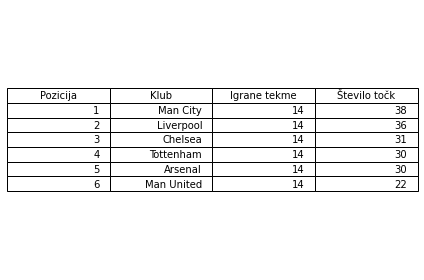

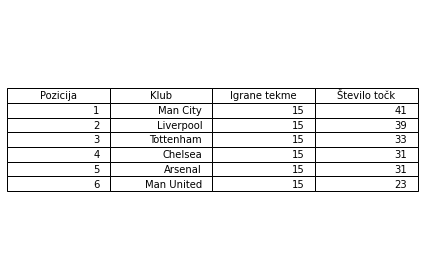

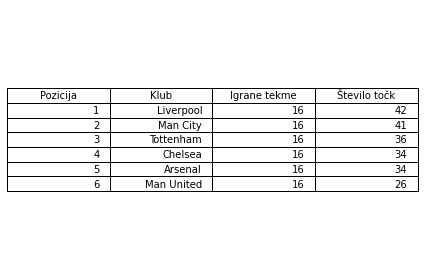

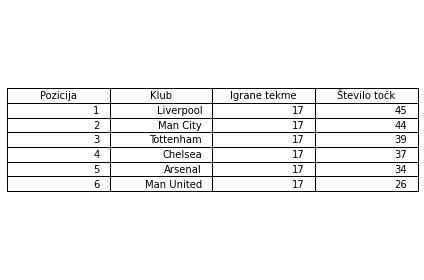

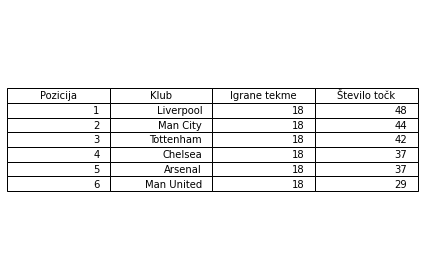

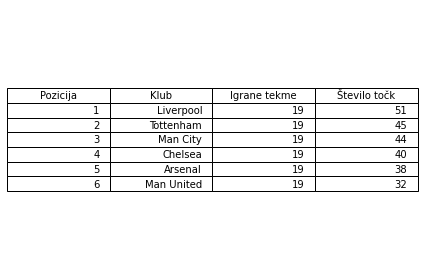

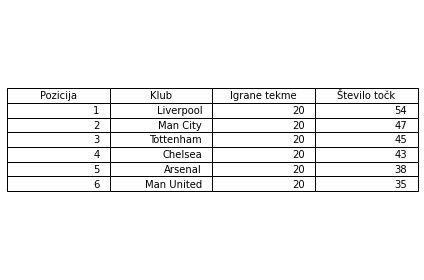

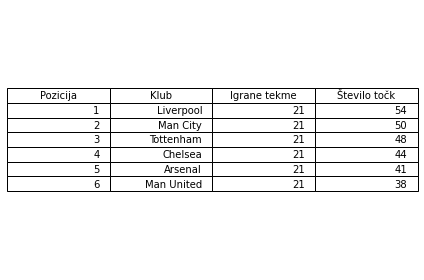

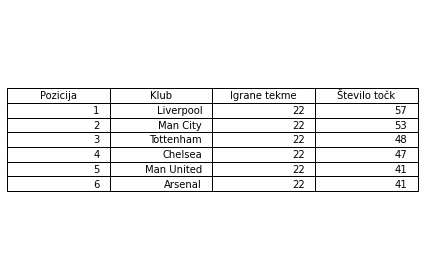

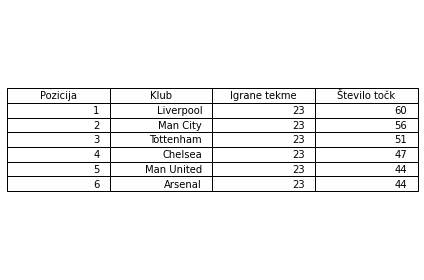

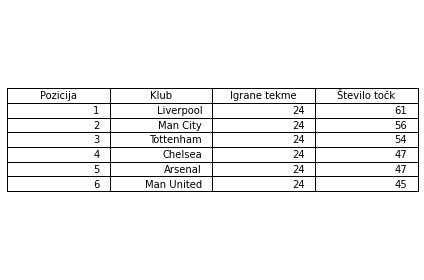

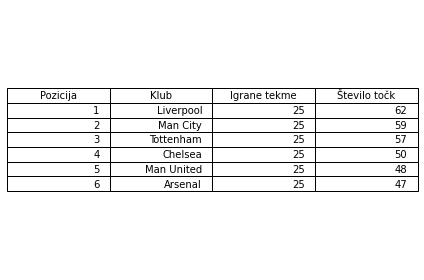

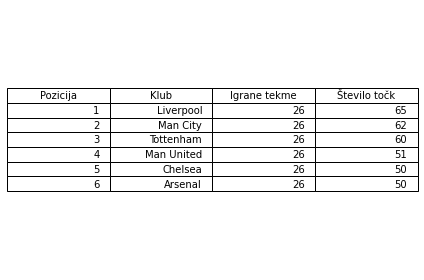

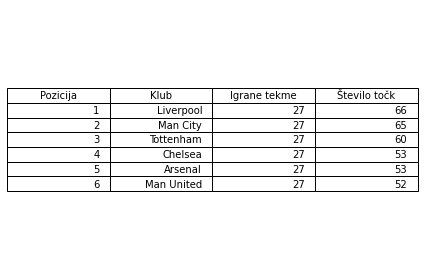

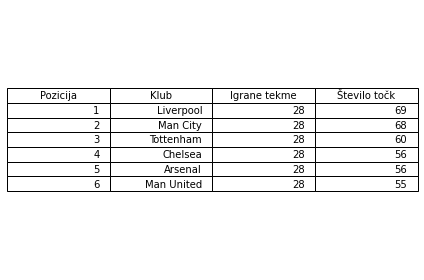

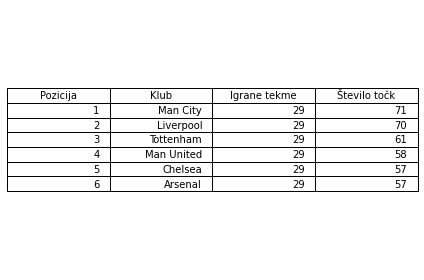

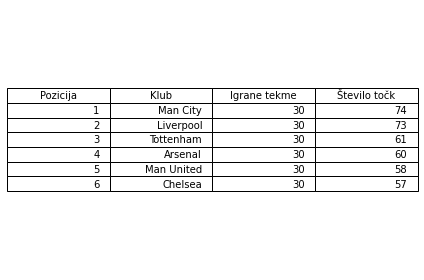

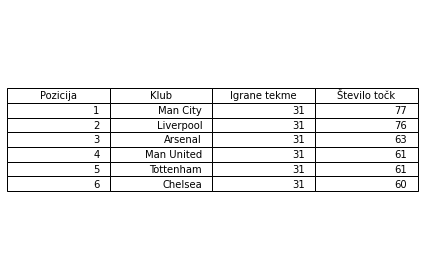

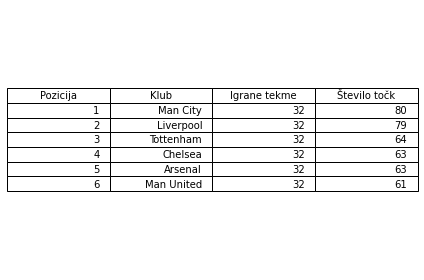

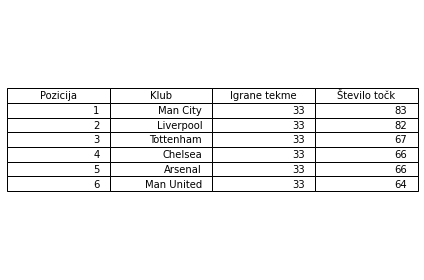

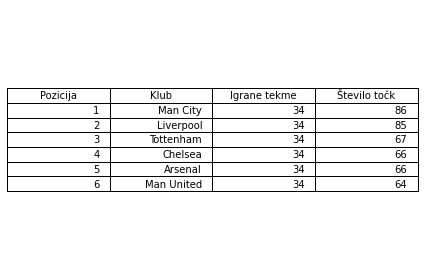

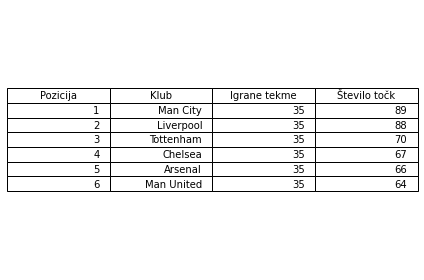

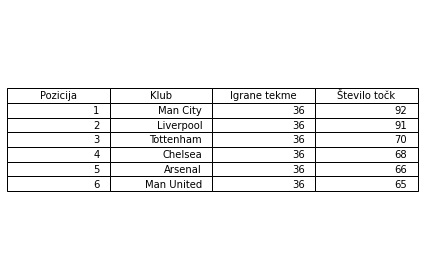

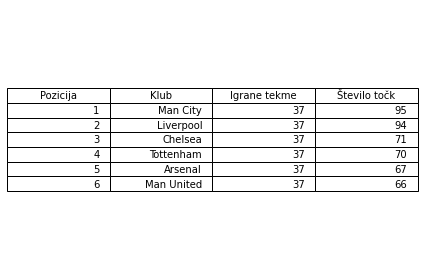

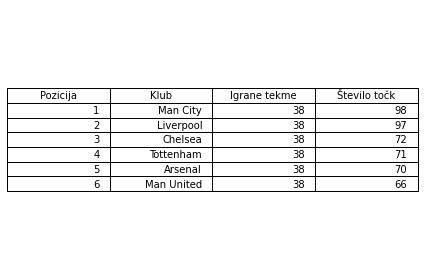

In [23]:
import os
import imageio
import natsort
plt.rcParams.update({'figure.max_open_warning': 0})
for i in range(0, 38):
    fig, ax = plt.subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    df = pd.DataFrame(season[i], columns=["Pozicija", "Klub", "Igrane tekme", "Število točk"])

    _= ax.table(cellText=df.values, colLabels=df.columns, loc='center')

    _= fig.tight_layout()
    _= fig.savefig(f'./assets/pictures/{i+1}.png')


png_dir = './assets/pictures/'
images = []
#folder = (os.listdir(png_dir)).sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
folder = natsort.natsorted(os.listdir(png_dir),reverse=False)
for file_name in folder:
    if file_name.endswith('.png'):
        #print(file_name)
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('./assets/gifs/season.gif', images, fps=1)



In [24]:
from IPython.display import HTML
HTML('<img src="./assets/gifs/season.gif">')

In [25]:
def convert_to_int(arr):
    #print(arr)
    for i, item in enumerate(arr):
        if item == '':
            arr[i] = 0
        else:
            if '%' in arr[i]:
                arr[i] = float(arr[i].replace("%", ""))
            elif ',' in arr[i]:
                arr[i] = float(arr[i].replace(",", "."))
            arr[i] = float(arr[i])
    return arr

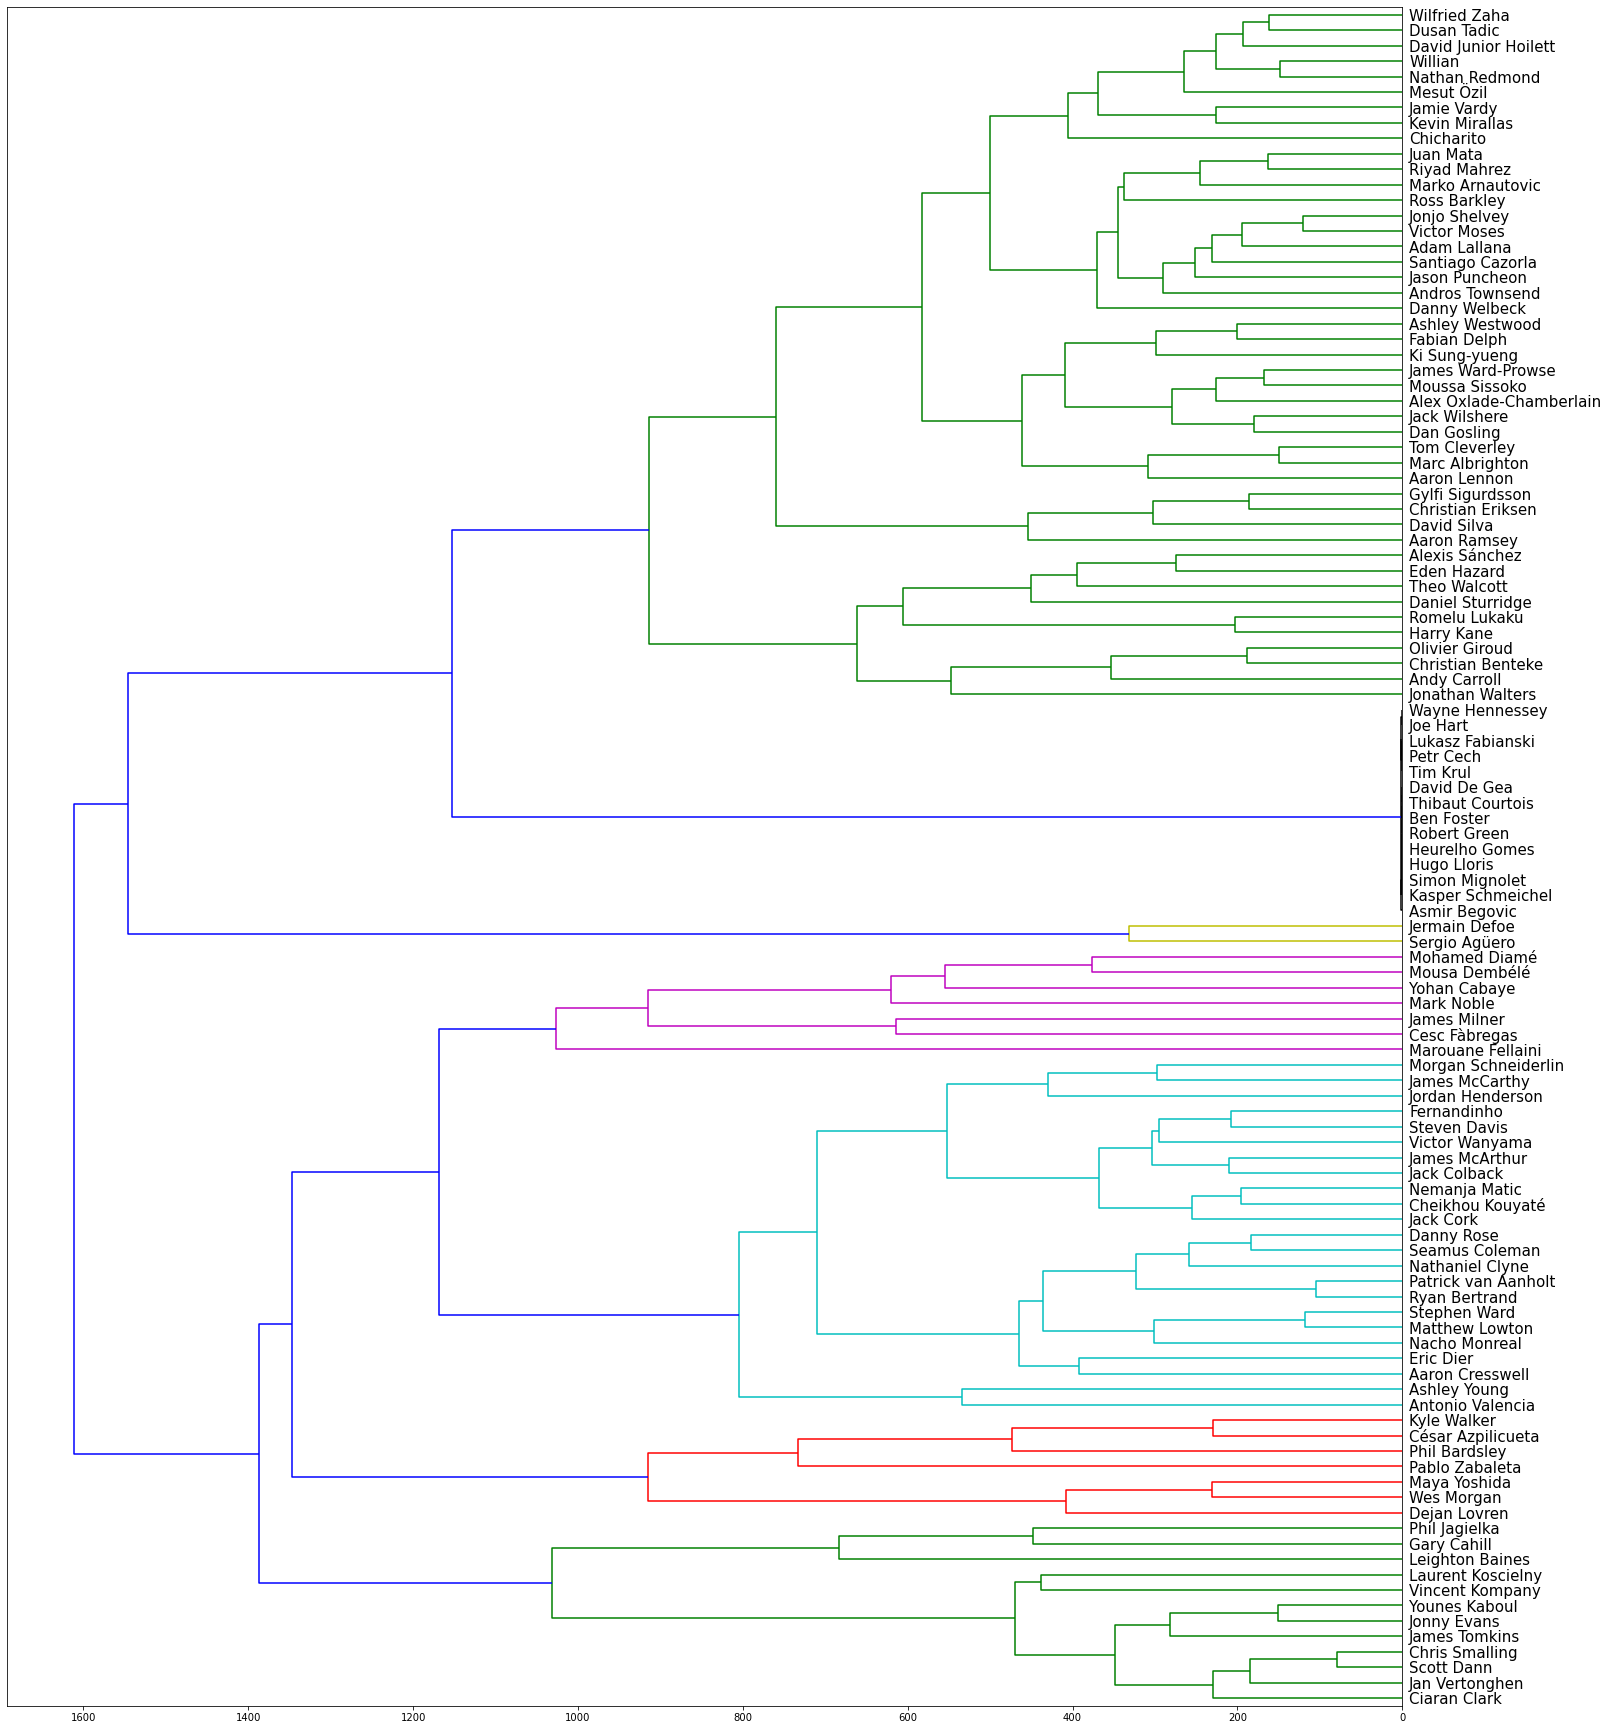

In [26]:
lim = 125
matr = [convert_to_int(v.get_all()) for k, v in players_dict.items() if int(v.apps) > lim ]
labels = [k for k, v  in players_dict.items() if int(v.apps) > lim]

import scipy.cluster.hierarchy as sch
X = matr
#L = sch.linkage(X, method="ward", metric="euclidean")
#L = sch.linkage(X, method="complete", metric="cityblock")
L = sch.linkage(X, method="average", metric="cityblock")
#L = sch.linkage(X, method="centroid", metric="euclidean")

plt.figure(figsize=(25, lim/4), facecolor='white')
D   = sch.dendrogram(L, labels=labels, leaf_font_size=15, orientation='left')

In [27]:
from sklearn.metrics import silhouette_score
t = 6
predictions = sch.fcluster(L, t=t, criterion="distance").ravel()
print(silhouette_score(X, predictions, metric="cityblock"))
    

0.1270442501951081
